### Question 3 - Lockdown detection

The full dataset covers periods of population confinements due to Covid 19. Can you find a statistical signal in the data showing air quality improvement coinciding with confinement periods in the countries covered by the data?

**Requeriment**: For this question, use a single framework of your choice, of those studied.

In [4]:
#@title Mount Google Drive
from google.colab import drive
drive.mount('/content/drive') # Faz o mount da drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
#@title Install Pyspark
!pip install --quiet pyspark # Faz a instalação do Pyspark

In [6]:
#@title Dataset
!head -100000 /content/drive/MyDrive/projeto_spbd/sds011-2020-01-0*.csv > files
!head -100000 /content/drive/MyDrive/projeto_spbd/sds011-2020-01-1*.csv >> files
!head -100000 /content/drive/MyDrive/projeto_spbd/sds011-2020-01-2*.csv >> files
!head -100000 /content/drive/MyDrive/projeto_spbd/sds011-2020-01-3*.csv >> files
!head -100000 /content/drive/MyDrive/projeto_spbd/sds011-2020-02-0*.csv >> files
!head -100000 /content/drive/MyDrive/projeto_spbd/sds011-2020-02-1*.csv >> files
!head -100000 /content/drive/MyDrive/projeto_spbd/sds011-2020-02-2*.csv >> files
!head -100000 /content/drive/MyDrive/projeto_spbd/sds011-2020-03-0*.csv >> files
!head -100000 /content/drive/MyDrive/projeto_spbd/sds011-2020-03-1*.csv >> files
!head -100000 /content/drive/MyDrive/projeto_spbd/sds011-2020-03-2*.csv >> files
!head -100000 /content/drive/MyDrive/projeto_spbd/sds011-2020-03-3*.csv >> files
!head -100000 /content/drive/MyDrive/projeto_spbd/sds011-2020-04-0*.csv >> files
!head -100000 /content/drive/MyDrive/projeto_spbd/sds011-2020-04-1*.csv >> files
!head -100000 /content/drive/MyDrive/projeto_spbd/sds011-2020-04-2*.csv >> files
!head -100000 /content/drive/MyDrive/projeto_spbd/sds011-2020-04-3*.csv >> files
!head -100000 /content/drive/MyDrive/projeto_spbd/sds011-2020-05-0*.csv >> files
!head -100000 /content/drive/MyDrive/projeto_spbd/sds011-2020-05-1*.csv >> files
!head -100000 /content/drive/MyDrive/projeto_spbd/sds011-2020-05-2*.csv >> files
!head -100000 /content/drive/MyDrive/projeto_spbd/sds011-2020-05-3*.csv >> files
!head -100000 /content/drive/MyDrive/projeto_spbd/sds011-2020-06-0*.csv >> files
!head -100000 /content/drive/MyDrive/projeto_spbd/sds011-2020-06-1*.csv >> files

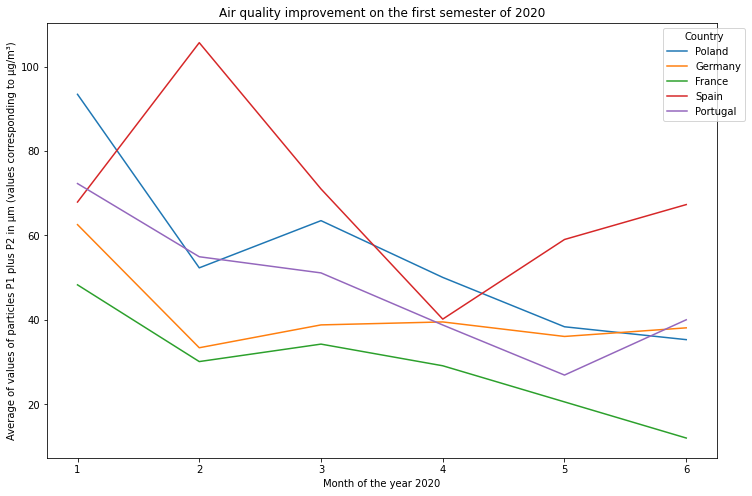

In [9]:
#@title Resolution using Spark DataFrame
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from google.colab import files

spark = SparkSession.builder.master('local[*]').appName('/content/files').getOrCreate() # É iniciada a SparkSession, em local mode
sc = spark.sparkContext # Cria o SparkContext

try :
    custom_schema = StructType([StructField("sen_id", StringType(), True),StructField("file_id", StringType(), True),StructField("lat", FloatType(), True),StructField("lon", FloatType(), True),StructField("timestamp", TimestampType(), True),StructField("p1", FloatType(), True),StructField("p2", FloatType(), True),])
    # É criado um schema para o DataFrame
    main_data = spark.read.schema(custom_schema).load('/content/files', sep=';', header=False, format="csv") # O dataset principal é atribuído ao schema criado
    aux_data=spark.read.json('/content/drive/MyDrive/projeto_spbd/sensors_all.json') # Carregamento do dataset secundário (JSON)
    df_joint=main_data.join(aux_data, main_data.sen_id == aux_data.sensor_id,"inner") \
                      .withColumn('month', month(main_data.timestamp)) \
                      .withColumn('sum_p1_p2', col("p1") + col("p2")) \
                      .groupBy(col("country"), col("month")) \
                      .agg(avg(col("sum_p1_p2")).alias("metric")) \
                      .orderBy(col("month"))
    # df_joint corresponde ao INNER JOINT entre os dois DataFrames, pelo sensor_id;
    # É criada a coluna month, que corresponde ao mês do ano, e a coluna sum_p1_p2, que corresponde à soma dos valores de p1 e p2;
    # É feito o groupBy pelo country e month;
    # É feito o AGG, onde é feita a média dos valores sum_p1_p2, e onde lhe é atribuída um nome, metric;
    # É feito o orderBy pela coluna month.

    #################### CRIA GRÁFICO ####################
    df = df_joint.toPandas()
    lista=['France','Poland','Spain','Germany','Portugal']
    df1 = df[df['country'].isin(lista)]
    plt.figure(figsize=(12, 8))
    ax = sns.lineplot(x='month', y='metric', hue='country', data=df1)
    ax.set(xlabel="Month of the year 2020", ylabel="Average of values of particles P1 plus P2 in µm (values corresponding to μg/m³)")
    plt.title("Air quality improvement on the first semester of 2020")
    plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc="best")
    plt.show()
    ######################################################
    # Através do gráfico é possível verificar um decréscimo acentuado nos volores da métrica no mês de fevereiro, em todos os países, excepto em Espanha;
    # É possível verificar que a tendência de valores abaixo da média mantém-se ao longo dos meses, apesar de haver pequenas flutuações;
    # Conclui-se, desta forma, que é possível verificar um ligeiro melhoramento do valor médio das métricas durante os períodos de confinamento.

except Exception as err:
    print(err)
    sc.stop()